In [1]:
# imports and setup
import pandas as pd
import numpy as np
import nltk
import stanza
import re
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# regex cleaning pattern
pattern = r'[^A-Za-z0-9]+'

In [2]:
# import corpora
stanza.download('en')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

2022-11-12 11:59:52 INFO: Downloading default packages for language: en (English) ...
2022-11-12 11:59:53 INFO: File exists: C:\Users\krish\stanza_resources\en\default.zip
2022-11-12 11:59:57 INFO: Finished downloading models and saved to C:\Users\krish\stanza_resources.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# initialise nlp pipeline
nlp = stanza.Pipeline()
sid = SentimentIntensityAnalyzer()

2022-11-12 11:59:57 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-12 11:59:59 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2022-11-12 11:59:59 INFO: Use device: cpu
2022-11-12 11:59:59 INFO: Loading: tokenize
2022-11-12 11:59:59 INFO: Loading: pos
2022-11-12 11:59:59 INFO: Loading: lemma
2022-11-12 11:59:59 INFO: Loading: depparse
2022-11-12 11:59:59 INFO: Loading: sentiment
2022-11-12 11:59:59 INFO: Loading: constituency
2022-11-12 12:00:00 INFO: Loading: ner
2022-11-12 12:00:00 INFO: Done loading processors!


In [4]:
# define some plot colours
colors = ['#142459', '#176BA0', '#19AADE', '#1AC9E6', '#1DE4BD', '#60F0D2', '#c7F9EE']

In [5]:
# read data from csv
reviews = pd.read_csv('data/Books_rating.csv')

In [6]:
# check first n rows of review text
reviews[['review/text', 'review/score']].iloc[:10]

,review/text,review/score
0,This is only for Julie Strain fans. It's a col...,4.0
1,I don't care much for Dr. Seuss but after read...,5.0
2,"If people become the books they read and if ""t...",5.0
3,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",4.0
4,Philip Nel - Dr. Seuss: American IconThis is b...,4.0
5,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",4.0
6,Theodor Seuss Giesel was best known as 'Dr. Se...,5.0
7,When I recieved this book as a gift for Christ...,5.0
8,Trams (or any public transport) are not usuall...,5.0
9,"As far as I am aware, this is the first book-l...",4.0


In [7]:
# set number of rows to sample and default maximum number of aspects:
n = 100
aspects = 8

In [8]:
# lowercase and tokenise
data = reviews[['review/text', 'review/score']].iloc[:n].apply(lambda x: x.astype(str).str.lower())
sentence_tokenized = data['review/text'].apply(nltk.sent_tokenize)

In [9]:
# define sentence cleaning, tokenization and parts of speech tagging function
def clean_sentence(sentence):
    clean_sentence = re.sub(pattern, ' ', sentence)
    token_clean = nltk.word_tokenize(clean_sentence)
    pos_clean = nltk.pos_tag(token_clean)
    return(pos_clean, clean_sentence, token_clean)

In [10]:
# clean and tokenize data
review_list = []
for review in sentence_tokenized:
    sentence_clean = []
    sentence_pos = []
    sentence_token = []
    for sentence in review:
        pos, clean, token = clean_sentence(sentence)
        sentence_pos.append(pos)
        sentence_clean.append(clean)
        sentence_token.append(token)
    review_dict = {"sentence": sentence_clean, "token": sentence_token, "pos": sentence_pos}
    review_list.append(review_dict)

In [11]:
# put tokenized data in dataframe
tokenized_data = pd.DataFrame(review_list)   
tokenized_data['scores'] = None
tokenized_data['duration'] = 0
tokenized_data = pd.concat([tokenized_data, data['review/score']], axis=1, join='inner')
tokenized_data.head()

,sentence,token,pos,scores,duration,review/score
0,"[this is only for julie strain fans , it s a c...","[[this, is, only, for, julie, strain, fans], [...","[[(this, DT), (is, VBZ), (only, RB), (for, IN)...",None,0,4.0
1,[i don t care much for dr seuss but after read...,"[[i, don, t, care, much, for, dr, seuss, but, ...","[[(i, JJ), (don, VBP), (t, EX), (care, NN), (m...",None,0,5.0
2,[if people become the books they read and if t...,"[[if, people, become, the, books, they, read, ...","[[(if, IN), (people, NNS), (become, VBP), (the...",None,0,5.0
3,[theodore seuss geisel 1904 1991 aka quot dr s...,"[[theodore, seuss, geisel, 1904, 1991, aka, qu...","[[(theodore, RB), (seuss, JJ), (geisel, NN), (...",None,0,4.0
4,[philip nel dr seuss american iconthis is basi...,"[[philip, nel, dr, seuss, american, iconthis, ...","[[(philip, NN), (nel, NNS), (dr, VBP), (seuss,...",None,0,4.0


In [12]:
# sentiment score calculator using nltk's Sentiment Analyzer
def sentiment_score(finalcluster):
    scores = []
    for pair in finalcluster:
        # only look at valid pairs
        if len(pair[1]) != 0:
            score = sid.polarity_scores(''.join(pair[1]))
            if score['compound'] != 0.0:
                pair_score = [pair, score['compound']]
                scores.append(pair_score)
    return(scores)

In [13]:
# given a sentence, find the dependencies
def find_relationships(doc, token, pos):
    # categories = []
    if doc.sentences[0].dependencies:
        dep_obj = []
        for dep in doc.sentences[0].dependencies:
            dep_obj.append([dep[2].text, dep[0].id, dep[1]])
        for item in range(0, len(dep_obj)):
            if (int(dep_obj[item][1]) != 0):
                dep_obj[item][1] = token[(int(dep_obj[item][1]) - 1)]
                
        # possible features if noun (NN, NNS), adjective (JJ, JJR) or adverb (RB)
        features = []
        for item in pos:
            # if(i[1]=='JJ' or i[1]=='NN' or i[1]=='JJR' or i[1]=='NNS' or i[1]=='RB'):
            if item[1] in ('RB', 'NNS', 'JJR', 'NN', 'JJ'):
                features.append(list(item))

        # cluster together features and descriptive words
        cluster = []
        for item in features:
            feature_list = []
            for i in dep_obj:
                if((item[0] in (i[0], i[1])) and (i[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                # if((i[0]==item[0] or i[1]==item[0]) and (i[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                    if(i[0]==item[0]):
                        feature_list.append(i[1])
                    else:
                        feature_list.append(i[0])
            cluster.append([item[0], feature_list])

        # select only nouns
        noun_cluster = []
        dict = {}
        for item in features:
            dict[item[0]] = item[1]
        for item in cluster:
            if(dict[item[0]]=="NN"):
                noun_cluster.append(item)

        # get sentence sentiment scores for all features (aspects) in cluster
        sentence_sentiment = sentiment_score(noun_cluster) 
    return(sentence_sentiment)

In [14]:
# refine aspect outputs and scores formatting (untangle lists of lists of lists)
def get_aspects(scores):
    aspects = []
    for x in scores:
        for y in x:
            aspects.append([y[0][0], y[0][1][0], y[1]])
    return(aspects)

In [15]:
# perform absa on given data, with chosen aspect limit and number of samples
def absa(tokenized_data, aspects = aspects, n = n):
    # loop through data
    #review level
    for i in tqdm(range(0, n)):
        start_review = time.time()
        current_aspects = 0
        # sentence level
        review_scores = []
        for j in range(0, len(tokenized_data['sentence'].loc[i]) - 1):
            current_aspects = len(review_scores)
            if current_aspects >= aspects:
                continue
            sentence = tokenized_data['sentence'].loc[i][j]
            pos = tokenized_data['pos'].loc[i][j]
            token = tokenized_data['token'].loc[i][j] 
            if len(sentence.strip()) == 0:
                continue
            else:
                doc = nlp(sentence)
                try:
                    scores = find_relationships(doc, token, pos)
                    if len(scores) != 0:
                        review_scores.append(scores)
                except:
                    continue

            # limit number of aspects processed
        tokenized_data['scores'].iloc[i] = review_scores[0:aspects]     
        duration = time.time() - start_review
        tokenized_data['duration'].loc[i] = duration  
    return(tokenized_data.iloc[:n])

In [16]:
# classify review based on aspect sentiment scores
def predict(scores):
    prediction = None
    prediction_sum = 0
    for x in scores:
        prediction_sum += float(x[2])
        if prediction_sum > 0:
            prediction = 'Positive'
        elif prediction_sum < 0:
            prediction = 'Negative'
        else:
            prediction = 'Neutral'
    return(prediction)

In [17]:
# format and measure output and print to csv
def measure(output, n, aspects):
    try:
        output['review/score'] = output['review/score'].apply(lambda x: int(x.replace('.0', '')))
    except:
        print('already converted to int!')
    output['label'] = np.where(output['review/score'] >= 3, 'Positive', 'Negative')
    output['label'] = np.where(output['review/score'] == 3, 'Neutral', output['label'])
    try:
        output['scores'] = output['scores'].apply(get_aspects)
    except:
        print('aspects already found!')
    output['prediction'] = output['scores'].apply(predict)
    output['correct'] = np.where(output['label'] == output['prediction'], 1, 0)
    if aspects < 10:
        output.to_csv('output/0' + str(aspects) + 'output(n' + str(n) + '_a' + str(aspects) + ').csv')
    else:
        output.to_csv('output/' + str(aspects) + 'output(n' + str(n) + '_a' + str(aspects) + ').csv')
    return(output)

In [18]:
# perform absa for each aspect limit in list (overrides default aspect) and save the output. The full list takes a while to be processed.
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]:
    a = i
    print('n =', n, 'a =', a)
    output = absa(tokenized_data = tokenized_data, aspects = a, n = n)
    measure(output, n, a)
print('done!')

n = 100 a = 1


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

n = 100 a = 2


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


n = 100 a = 3


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


n = 100 a = 4


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:27<00:00,  2.08s/it]


n = 100 a = 5


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


n = 100 a = 6


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:48<00:00,  2.28s/it]


n = 100 a = 7


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:51<00:00,  2.31s/it]


n = 100 a = 8


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


n = 100 a = 9


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


n = 100 a = 10


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


n = 100 a = 15


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


n = 100 a = 20


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_15224\2723694860.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
100%|██████████| 100/100 [03:16<00:00,  1.97s/it]

done!


In [19]:
# read output into comparitive time_series and percentage of correct predictions
time_series = pd.DataFrame(columns = ['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20'])
# correct = pd.DataFrame(columns = ['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20'])
correct = []
a = 1
for filename in os.listdir('output/'):
    print(a, filename)
    output_file = pd.read_csv('output/' + filename)
    series = output_file['duration'].cumsum()
    column = 'a=' + str(a)
    time_series[column] = series
    correct.append(output_file['correct'].sum()/73)
    if a< 10:
        a += 1
    else:
        a += 5


1 01output(n100_a1).csv
2 02output(n100_a2).csv
3 03output(n100_a3).csv
4 04output(n100_a4).csv
5 05output(n100_a5).csv
6 06output(n100_a6).csv
7 07output(n100_a7).csv
8 08output(n100_a8).csv
9 09output(n100_a9).csv
10 10output(n100_a10).csv
15 15output(n100_a15).csv
20 20output(n100_a20).csv


In [20]:
time_series

,a=1,a=2,a=3,a=4,a=5,a=6,a=7,a=8,a=9,a=10,a=15,a=20
0,0.147027,0.171023,0.133516,0.127517,0.158311,0.152784,0.185934,0.151393,0.166572,0.142700,0.151250,0.137614
1,2.288888,3.446102,3.372182,3.384459,3.911230,4.006223,3.905699,3.859254,3.630923,3.750453,3.719983,3.306875
2,3.345574,4.781686,7.332832,7.691333,9.214426,9.184706,8.942663,8.747930,8.261168,8.455180,8.445497,7.459186
3,8.561917,11.432103,14.756381,15.612771,18.469935,18.502401,18.108365,17.991035,16.535857,16.743519,16.717310,14.900944
4,12.384431,15.439590,18.760308,19.598761,23.010070,23.033740,22.743014,22.395718,20.810236,21.007184,20.943419,18.614133
...,...,...,...,...,...,...,...,...,...,...,...,...
95,93.932214,142.105019,170.817423,195.287381,207.946114,215.691880,218.948093,208.354584,209.998805,205.238574,202.110717,185.501409
96,94.356268,143.713422,172.873315,197.619470,210.307830,218.124424,221.238853,210.521655,212.243577,207.395585,204.079679,187.592221
97,94.637810,143.998466,173.158848,197.932431,210.672674,218.464543,221.583487,210.819489,212.543061,207.693399,204.376629,187.869888
98,97.150921,149.047278,178.513532,204.057934,216.722898,224.599493,227.588136,216.623074,218.590325,213.435986,209.442474,193.302309


In [21]:
correct

[0.7397260273972602,
 0.726027397260274,
 0.726027397260274,
 0.726027397260274,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466,
 0.7534246575342466]

In [22]:
columns = ['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20']
time_series.loc[99].index[0]
time_series.loc[99].values[0]


98.92882513999939

Text(100, 196.55148816108704, 'a=20')

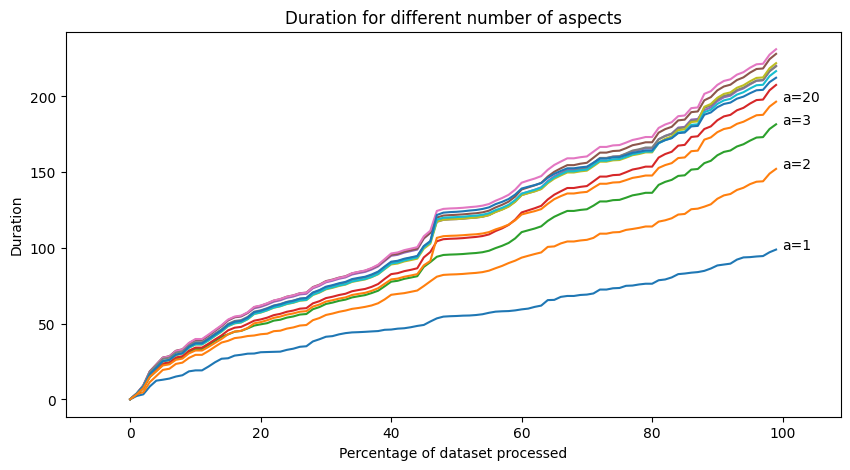

In [23]:
# Time series of daily reviews
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_series)
ax.set_ylabel('Duration')
ax.set_xlabel('Percentage of dataset processed')
ax.set_title('Duration for different number of aspects')
ax.margins(x=0.1)
for i in range(0, 3):
    plt.text(100, time_series.loc[99].values[i], time_series.loc[99].index[i])
# plt.text(100, time_series.loc[99].values[9], time_series.loc[99].index[9])
plt.text(100, time_series.loc[99].values[11], time_series.loc[99].index[11])


In [24]:
# get number of aspects per review
aspect_length= []
aspect_df = pd.DataFrame(columns = ['aspects'])
for i in range(0, len(output['scores'])):
    aspect_length.append(len(output['scores'].loc[i]))
aspect_df['aspects'] = aspect_length
aspect_df['aspects'].head()

0    1
1    2
2    3
3    4
4    1
Name: aspects, dtype: int64

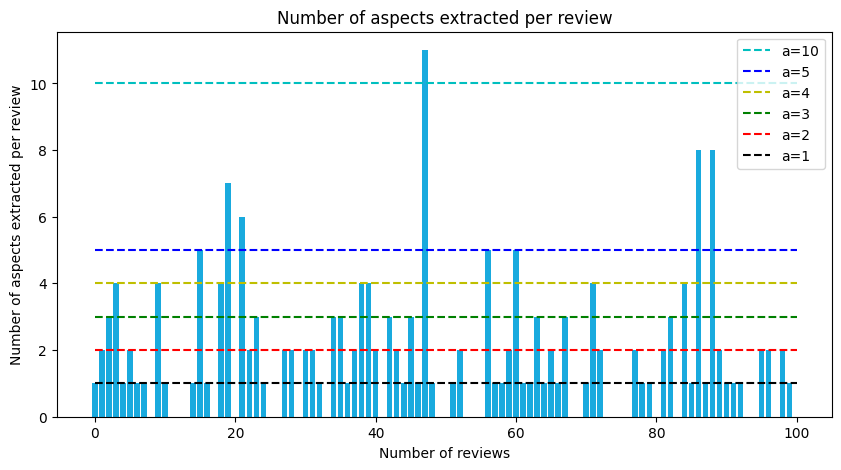

In [25]:
# plot aspects per review. Make sure that the last asba model run was for a = 20 to show all possible aspects
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(aspect_df.index, aspect_df['aspects'], color = colors[2])
ax.set_ylabel('Number of aspects extracted per review')
ax.set_xlabel('Number of reviews')
ax.set_title('Number of aspects extracted per review')
line10, = ax.plot([0, 100], [10, 10], "c--", label = 'a=10')
line5, = ax.plot([0, 100], [5, 5], "b--", label = 'a=5')
line4, = ax.plot([0, 100], [4, 4], "y--", label = 'a=4')
line3, = ax.plot([0, 100], [3, 3], "g--", label = 'a=3')
line2, = ax.plot([0, 100], [2, 2], "r--", label = 'a=2')
line1, = ax.plot([0, 100], [1, 1], "k--", label = 'a=1')
line1.set_label('a=1')
line2.set_label('a=2')
line3.set_label('a=3')
line4.set_label('a=4')
line5.set_label('a=5')
line10.set_label('a=10')
ax.legend()
plt.show()

Text(0.5, 1.0, 'Percentage of correct sentiment classifications per number of allowed aspects (a)')

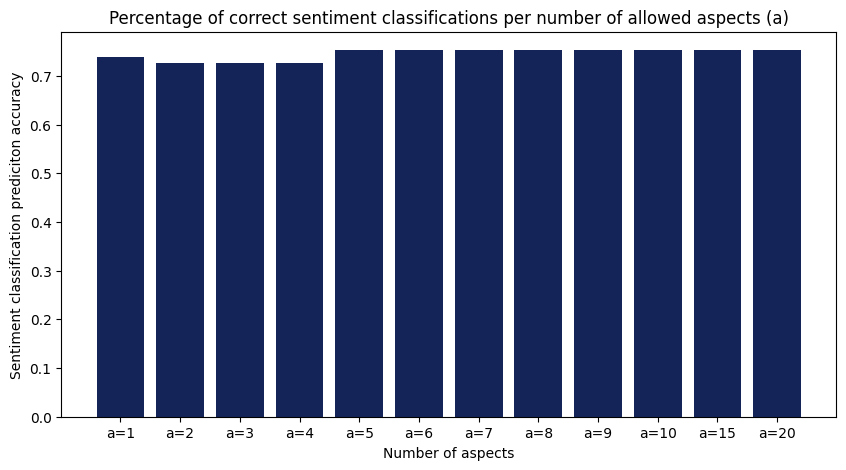

In [26]:
# prediction accuracy
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['a=1', 'a=2', 'a=3', 'a=4', 'a=5', 'a=6', 'a=7', 'a=8', 'a=9', 'a=10', 'a=15', 'a=20'], correct, color = colors[0])
ax.set_ylabel('Sentiment classification prediciton accuracy')
ax.set_xlabel('Number of aspects')
ax.set_title('Percentage of correct sentiment classifications per number of allowed aspects (a)')